In [136]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import networkx as nx

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
from itertools import combinations
from scipy.stats import hypergeom
import math

class CoCo:
    """Class to calculate the CoCo Score for a given gene-set in a network."""
    def __init__(self, total_nodes, total_interactions, total_triangles, local_nodes, local_interactions, local_triangles):
        self.Nint = total_nodes * (total_nodes - 1) / 2
        self.Kint = total_interactions
        self.nint = local_nodes * (local_nodes - 1) / 2
        self.kint = local_interactions
        self.Ntri = total_nodes * (total_nodes - 1) * (total_interactions - 2) / 6
        self.Ktri = total_triangles
        self.ntri = local_nodes * (local_nodes - 1) * (local_nodes - 2) / 6
        self.ktri = local_triangles

    def _compute_score(self, k, n, K, N):
        if k == 0 or n == 0:
            return 0
        sign = (k / n) - (K / N)
        p = hypergeom.pmf(k, N, K, n)
        return 0 if p == 0 else abs(math.log10(p)) * (-1 if sign < 0 else 1)

    @property
    def CoI(self):
        return self._compute_score(self.kint, self.nint, self.Kint, self.Nint)

    @property
    def CoT(self):
        return self._compute_score(self.ktri, self.ntri, self.Ktri, self.Ntri)

    @property
    def coco(self):
        return self.CoI + self.CoT




class WeightedGraph:
    def __init__(self):
        self.graph = {}

    def node_exists(self, node):
        """Check if a node exists in the graph."""
        return node in self.graph

    def edge_exists(self, node1, node2):
        """Check if an edge exists between node1 and node2."""
        return self.node_exists(node1) and node2 in self.graph[node1]

    def add_node(self, node):
        """Add a node to the graph."""
        if not self.node_exists(node):
            self.graph[node] = {}

    def add_edge(self, node1, node2, weight):
        """Add an edge between node1 and node2 with the given weight."""
        if not self.edge_exists(node1, node2):
            # If the nodes don't exist, add them to the graph
            self.add_node(node1)
            self.add_node(node2)

            # Add node2 as a neighbor of node1 and vice versa
            self.graph[node1][node2] = float(weight)
            # self.graph[node2][node1] = weight  # Assuming it's an undirected graph

    def get_edge_weight(self,node1,node2):  
        return self.graph[node1][node2]
        
    def get(self,input):
        """Returns dictionary associated with input key"""
        return self.graph.get(input)

    @property
    def get_triangles_count(self):
        triangles = 0

        for node in self.graph:
            neighbors = list(self.graph[node].keys())
            for i in range(len(neighbors)):
                for j in range(i+1, len(neighbors)):
                    if self.edge_exists(neighbors[i], neighbors[j]):
                        triangles += 1

        # Each triangle is counted 3 times (once for each node), so divide by 3
        return triangles // 3

    @property
    def get_edges_count(self, threshold=0.45):
        total_edges = sum(1 for neighbors in self.graph.values() for weight in neighbors.values() if weight > threshold)
        return total_edges // 2



    def __str__(self):
        return str(self.graph)

def count_edges_in_subgraph(graph, nodes):
    edge_count = 0

    # Check each pair of nodes
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if nodes[j] in graph[nodes[i]]:
                edge_count += 1

    return edge_count

def count_triangles_in_subgraph(graph, nodes):
    triangle_count = 0

    # Check every combination of three nodes
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            for k in range(j+1, len(nodes)):
                node1, node2, node3 = nodes[i], nodes[j], nodes[k]
                if (node2 in graph[node1] and node3 in graph[node1] and
                    node3 in graph[node2]):
                    triangle_count += 1

    return triangle_count

def find_max_coco_subgraph(graph):  # Added threshold parameter with default value 0
    nodes = list(graph.graph.keys())
    total_nodes = len(nodes)
    total_interactions = graph.get_edges_count if hasattr(graph, 'get_edges_count') else 0
    # For simplicity, let's assume the graph has a method to compute total triangles
    total_triangles = graph.get_triangles_count if hasattr(graph, 'get_triangles_count') else 0

    max_score = -float('inf')
    best_subgraph = None
    r = 5 # How large you want your subgraph sizes to be

    # For simplicity, let's check all subgraphs of size 3
    for subgraph_nodes in combinations(nodes, r):
        local_nodes = len(subgraph_nodes)

        # Count edges in the subgraph using the provided function
        local_interactions = count_edges_in_subgraph(graph.graph, subgraph_nodes)

        # Count triangles in the subgraph using the provided function
        local_triangles = count_triangles_in_subgraph(graph.graph, subgraph_nodes)

        coco = CoCo(total_nodes, total_interactions, total_triangles, local_nodes, local_interactions, local_triangles)
        if coco.coco > max_score:
            max_score = coco.coco
            best_subgraph = subgraph_nodes
            G = nx.Graph()
            for node in range(0,r):
                for x in range (0, r):
                    if node == x:
                        pass
                    elif graph.edge_exists(best_subgraph[node], best_subgraph[x]):
                        G.add_edge(best_subgraph[node], best_subgraph[x], weight = float(graph.get_edge_weight(best_subgraph[node], best_subgraph[x])))
                    elif graph.edge_exists(best_subgraph[x], best_subgraph[node]):
                        G.add_edge(best_subgraph[x], best_subgraph[node], weight = float(graph.get_edge_weight(best_subgraph[x], best_subgraph[node])))
            elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
            esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]
            pos = nx.spring_layout(G, seed=7)
            # nodes
            nx.draw_networkx_nodes(G, pos, node_size=700)

            # edges
            nx.draw_networkx_edges(G, pos, edgelist=elarge, width=1)
            nx.draw_networkx_edges(
                G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
            )
            
            # node labels
            nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
            edge_labels = nx.get_edge_attributes(G, "weight")
            nx.draw_networkx_edge_labels(G, pos, edge_labels)
            
            ax = plt.gca()
            ax.margins(0.08)
            plt.axis("off")
            plt.tight_layout()
            plt.show()
            print(f'best sub: {best_subgraph}, max coco: {max_score}')

    return best_subgraph, max_score




In [138]:
############################################
### PAGER functions for PAGER server API ###
############################################
import requests
import numpy as np
import pandas as pd
class PAGER():
    def __init__(self):
        self.params = {}

    ######
    # run_pager is a function connected to PAGER api to perform hypergeometric test and retrieve enriched PAGs associated to a list of genes
    # The input parameters are:
    # 1.genes: a list of gene symbols.
    # 2.source: a list of sources refered to 'http://discovery.informatics.uab.edu/PAGER/index.php/pages/help'
    # 3.Type: a list of PAG types consisting of 'P', 'A' or 'G'
    # 4.minSize: the allowed minimum size of PAG genes
    # 5.maxSize: the allowed maximum size of PAG genes
    # 6.similarity: the similarity score cutoff [0,1]
    # 7.overlap: the allowed minimum overlap genes
    # 8.nCoCo: the minimum nCoCo score
    # 9.pValue: p-value cutoff
    # 10.FDR: false discovery rate
    ######
    def run_pager(self, genes,**kwargs):
        source = kwargs['source'] if 'source' in kwargs.keys() else ['KEGG_2021_HUMAN', 'WikiPathway_2021', 'BioCarta', 'Reactome_2021', 'Spike']
        Type = kwargs['Type'] if 'Type' in kwargs.keys() else 'All'
        minSize = kwargs['minSize'] if 'minSize' in kwargs.keys() else 1
        maxSize = kwargs['maxSize'] if 'maxSize' in kwargs.keys() else 2000
        sim = kwargs['similarity'] if 'similarity' in kwargs.keys() else 0
        overlap = kwargs['overlap'] if 'overlap' in kwargs.keys() else '1'
        organism = kwargs['organism'] if 'organism' in kwargs.keys() else 'All'
        nCoCo = kwargs['nCoCo'] if 'nCoCo' in kwargs.keys() else '0'
        pvalue = kwargs['pvalue'] if 'pvalue' in kwargs.keys() else 0.05
        FDR = kwargs['FDR'] if 'FDR' in kwargs.keys() else 0.05
        # Set up the call parameters as a dict.
        params = {}
        # Work around PAGER API form encode issue.
        params['genes'] = '%20'.join(genes)
        params['source'] = '%20'.join(source)
        params['type'] = Type
        params['ge'] = minSize
        params['le'] = maxSize
        params['sim'] = str(sim)
        params['olap'] = str(overlap)
        params['organism'] = organism
        params['cohesion'] = str(nCoCo)
        params['pvalue'] = pvalue
        params['FDR'] = FDR
        response = requests.post('http://discovery.informatics.uab.edu/PAGER/index.php/geneset/pagerapi', data=params)
        #print(response.request.body)
        return pd.DataFrame(response.json())

    # pathMember is a function connected to PAGER api to retrieve the membership of PAGs using a list of PAG IDs
    def pathMember(self, PAG_IDs):
        # Set up the call parameters as a dict.
        params = {}
        params['pag'] = ','.join(PAG_IDs)
        # Work around PAGER API form encode issue.
        response = requests.post('http://discovery.informatics.uab.edu/PAGER/index.php/geneset/get_members_by_ids/', data=params)
        #print(response.request.body)
        return pd.DataFrame(response.json()['data'])

    # pathInt is a function connected to PAGER api to retrieve the m-type relationships of PAGs using a list of PAG IDs
    def pathInt(self, PAG_IDs):
        # Set up the call parameters as a dict.
        params = {}
        params['pag'] = ','.join(PAG_IDs)
        # Work around PAGER API form encode issue.
        response = requests.post('http://discovery.informatics.uab.edu/PAGER/index.php/pag_pag/inter_network_int_api/', data=params)
        #print(response.request.body)
        return pd.DataFrame(response.json()['data'])

    # pathReg is a function connected to PAGER api to retrieve the r-type relationships of PAGs using a list of PAG IDs
    def pathReg(self, PAG_IDs):
        # Set up the call parameters as a dict.
        params = {}
        params['pag'] = ','.join(PAG_IDs)
        # Work around PAGER API form encode issue.
        response = requests.post('http://discovery.informatics.uab.edu/PAGER/index.php/pag_pag/inter_network_reg_api/', data=params)
        #print(response.request.body)
        return pd.DataFrame(response.json()['data'])

    # pagRankedGene is a function connected to PAGER api to retrieve RP-ranked genes with RP-score of the given PAG_IDs
    def pagRankedGene(self, PAGid):
        response = requests.get('http://discovery.informatics.uab.edu/PAGER/index.php/genesinPAG/viewgenes/'+PAGid)
        return pd.DataFrame(response.json()['gene'])

    # pagGeneInt is a function connected to PAGER api to retrieve gene interaction network
    def pagGeneInt(self, PAGid):
        response = requests.get('http://discovery.informatics.uab.edu/PAGER/index.php/pag_mol_mol_map/interactions/'+PAGid)
        return pd.DataFrame(response.json()['data'])

    # pagGeneReg is a function connected to PAGER api to retrieve gene regulatory network
    def pagGeneReg(self, PAGid):
        response = requests.get('http://discovery.informatics.uab.edu/PAGER/index.php/pag_mol_mol_map/regulations/'+PAGid)
        return pd.DataFrame(response.json()['data'])

    # path_NGSEA is a function connected to PAGER api to generate the network-based GSEA result
    import requests
    def path_NGSEA(SELF, genes, PAGmember):
        geneExpStr = ''
        for rowIdx in range(0,genes.shape[0]):
            geneExpStr = geneExpStr + genes.iloc[rowIdx,0]+'\\t\\t'+genes.iloc[rowIdx,1] + "\\t\\t\\t"
        PAGsetsStr = ''
        for rowIdx in range(0,PAGmember.shape[0]):
            PAGsetsStr = PAGsetsStr + PAGmember.iloc[rowIdx,0]+'\\t\\t'+PAGmember.iloc[rowIdx,1] + "\\t\\t\\t"
        params = {}
        params['geneExpStr'] = geneExpStr
        params['PAGsetsStr'] = PAGsetsStr
        response = requests.post('http://discovery.informatics.uab.edu/PAGER/index.php/geneset/ngseaapi/', data=params)
        #print(response.request.body)
        return pd.DataFrame(response.json()['data'])


In [139]:
PAGER = PAGER()

In [140]:
######
# run_pager is a function connected to PAGER api to perform hypergeometric test and retrieve enriched PAGs associated to a list of genes
# The input parameters are:
# 1.genes: a list of gene symbols.
# 2.source: a list of sources refered to 'http://discovery.informatics.uab.edu/PAGER/index.php/pages/help'
# 3.Type: a list of PAG types consisting of 'P', 'A' or 'G'
# 4.minSize: the allowed minimum size of PAG genes
# 5.maxSize: the allowed maximum size of PAG genes
# 6.similarity: the similarity score cutoff [0,1]
# 7.overlap: the allowed minimum overlap genes
# 8.nCoCo: the minimum nCoCo score
# 9.pValue: p-value cutoff
# 10.FDR: false discovery rate
######
PAG_result = PAGER.run_pager(
    ['BRCA1'],
    source = [ 'BioCarta'],
    # source = ['KEGG_2021_HUMAN', 'WikiPathway_2021', 'BioCarta', 'Reactome_2021', 'Spike'],
    Type='All',
    minSize=1,
    maxSize=2000,
    similarity = 0.05,
    overlap = 1,
    nCoCo = 0,
    pValue = 0.05,
    FDR = 0.05
)
PAG_result

,GS_ID,NAME,SOURCE,GS_SIZE,ORGANISM,DESCRIPTION,LINK,TYPE,MULTI_N,OLAP,COCO_V2,SIMILARITY_SCORE,pvalue,Rank,pFDR
0,WAG000212,brca1 dependent ub ligase activity,BioCarta,8,Homo sapiens,BRCA1 is a breast and ovarian cancer tumor sup...,https://cgap.nci.nih.gov/Pathways/BioCarta/h_b...,P,252,1,2952.437543547,.3,0.000181,1,0.000723
1,WAG000628,atm signaling pathway,BioCarta,18,Homo sapiens,The ataxia telangiectasia-mutated gene (ATM) e...,https://cgap.nci.nih.gov/Pathways/BioCarta/h_a...,P,252,1,2452.4696816816,.2444444444444444444444444444444444444444,0.000407,2,0.001220
2,WAG000012,cell cycle: g2/m checkpoint,BioCarta,20,Homo sapiens,The G2/M D damage checkpoint prevents the cell...,https://cgap.nci.nih.gov/Pathways/BioCarta/h_g...,P,252,1,2018.86410526798,.24,0.000452,3,0.000904
3,WAG000644,role of brca1 brca2 and atr in cancer suscepti...,BioCarta,21,Homo sapiens,BRCA1 and BRCA2 were identified genetically as...,https://cgap.nci.nih.gov/Pathways/BioCarta/h_a...,P,252,1,5956.81576926631,.2380952380952380952380952380952380952381,0.000474,4,0.000474


,SYM_A,SYM_B,H_SCORE
0,BARD1,BRCA1,1
1,BARD1,FANCA,.921
2,BARD1,FANCC,.926
3,BARD1,FANCD2,.9732
4,BARD1,FANCE,.931
...,...,...,...
360,RAD51,RAD9A,.888
361,RAD51,TP53,.9754
362,RAD9A,TP53,.871
363,RAD9A,TREX1,.6804


{'MAPK8': 0.9961, 'MDM2': 0.999, 'NFKBIA': 0.8501, 'RELA': 0.9645, 'TP53': 0.9202}
{'FANCA': 0.9881, 'FANCC': 0.8698, 'FANCD2': 1.0, 'FANCE': 0.954, 'FANCF': 0.834, 'FANCG': 0.8486, 'CHEK1': 0.9516, 'CHEK2': 0.9998, 'GADD45A': 0.982, 'JUN': 0.9634, 'MAPK8': 0.6872, 'MDM2': 0.6314, 'RAD51': 1.0, 'RBBP8': 1.0, 'RELA': 0.9645, 'RPA1': 0.9885, 'TP53': 1.0, 'TP73': 0.9391, 'TREX1': 0.6, 'CCNB1': 0.9939, 'CDKN1A': 0.9285, 'CDKN2D': 0.9999, 'PRKDC': 0.9296, 'BRCA2': 0.9999, 'NBN': 1.0, 'RAD17': 0.532, 'RAD50': 0.9923, 'RAD9A': 0.508}


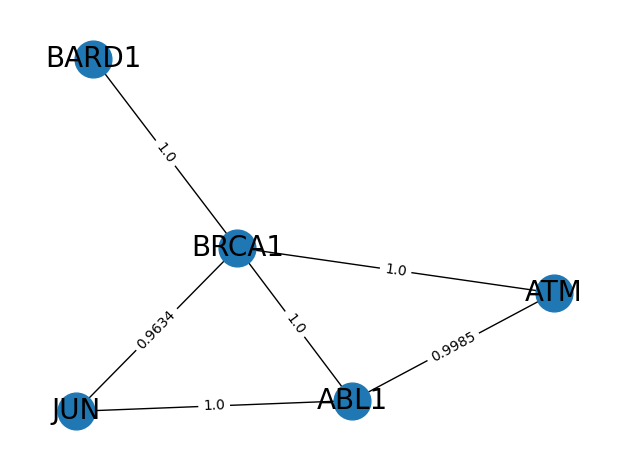

best sub: ('BARD1', 'BRCA1', 'ABL1', 'ATM', 'JUN'), max coco: 1.374965299512294


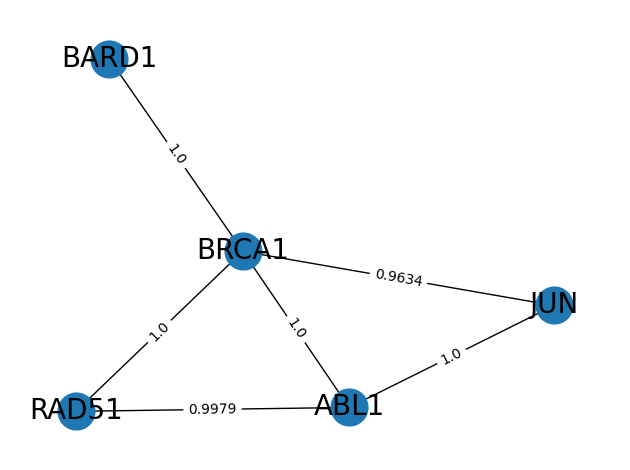

best sub: ('BARD1', 'BRCA1', 'ABL1', 'JUN', 'RAD51'), max coco: 2.047478008546958


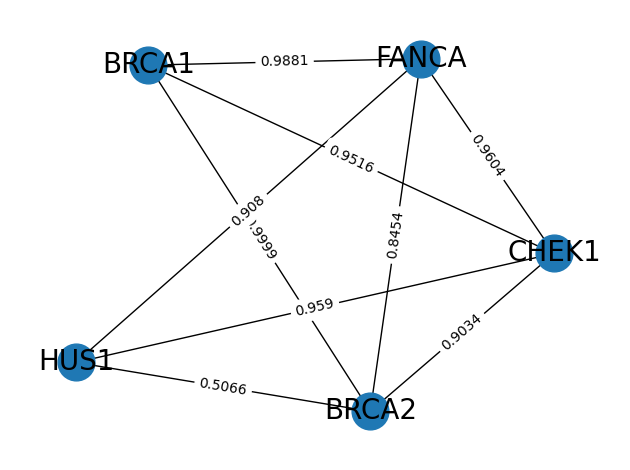

best sub: ('BRCA1', 'FANCA', 'CHEK1', 'BRCA2', 'HUS1'), max coco: 2.8819895403124574


KeyboardInterrupt: 

In [141]:
# pagGeneInt is a function connected to PAGER api to retrieve gene interaction network
# example:

# pagGeneInts = PAGER.pagGeneInt(list(PAG_result.GS_ID)[0])
# %debug
all_pagGeneInts = pd.concat([PAGER.pagGeneInt(gs_id) for gs_id in list(PAG_result.GS_ID)], ignore_index=True)
all_pagGeneInts
pag_graph = WeightedGraph()
for node1, node2, weight in all_pagGeneInts.values.tolist():
  pag_graph.add_edge(node1, node2, weight)

pag_graph

startTime = time.time()
BEST_SUB, MAX_COCO = find_max_coco_subgraph(pag_graph)
totalTime = round((time.time() - startTime), 2)
remainder = round(totalTime % 60, 2)
minutes = round(totalTime // 60, 0)

BEST_SUB
MAX_COCO

str(int(minutes)) + " minutes " + str(remainder) + " seconds"

In [ ]:
with open('TimeElapsed.txt') as f: #lines in text file
    size=len([0 for _ in f])
    print(size)
    minutes = int(minutes)
    if size == 0:
        with open('TimeElapsed.txt', 'w') as f: #if nothing in file, write this
            f.write("Elapsed time for run 0: " + str(minutes) + " minutes, " + str(remainder) + " seconds\n")
            f.write("Average time: " + str(minutes) + " minutes, " + str(remainder) + " seconds")
    else:
        with open('TimeElapsed.txt') as f: #get last line(lastLine) and array of lines(lines)
            lines = f.readlines()
            lastLine = lines[-1]
            lines = lines[:-1]
        with open('TimeElapsed.txt', 'w') as f:
            for line in lines:
                f.write(line)
            f.write("Elapsed time for run " + str(size - 1) + ": " + str(minutes) + " minutes " + str(remainder) + " seconds\n")        
            numRuns = size
            minFlag = False
            secFlag = False
            for char in range(0,len(lastLine)):
                if lastLine[char].isdigit() and minFlag == False:
                    avgMinutes = lastLine[char]
                    minFlag = True
                elif minFlag == True and lastLine[char].isdigit() and secFlag == False:
                    avgSeconds = lastLine[char:char + 5:1]
                    secFlag = True
                else:
                    pass
            oldAvg = (((int(avgMinutes) * 60) + float(avgSeconds)) * ((numRuns - 1)/ numRuns)) #Weight of all other runs
            newAvg = (oldAvg + (totalTime * (1 / numRuns))) #Now include weight of new run
            newMinutes = int(newAvg // 60)
            newSeconds = round(float(newAvg % 60), 2)
            f.write("Average time for runs: " + str(newMinutes) + " minutes " + str(newSeconds) + " seconds\n")


5


49

48

48

48

47

47